In [48]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn import cluster, metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

In [2]:
current_dir = os.getcwd()
project_dir = os.path.abspath(os.path.join(current_dir, ".."))
DATA_PATH = f"{project_dir}/data/"

# télécharger les fichiers
customers_base = pd.read_csv(DATA_PATH+"processed/customers_base.csv")
data = customers_base[['review_score', 'recency', 'payment_value',
                       'payment_installments', 'payment_sequential', 'order_id',
                       'payment_type_num', 'customer_state_encoded', 'payment_type_encoded']]
data.dropna(inplace=True)


/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


# Kmeans

(90938, 9)


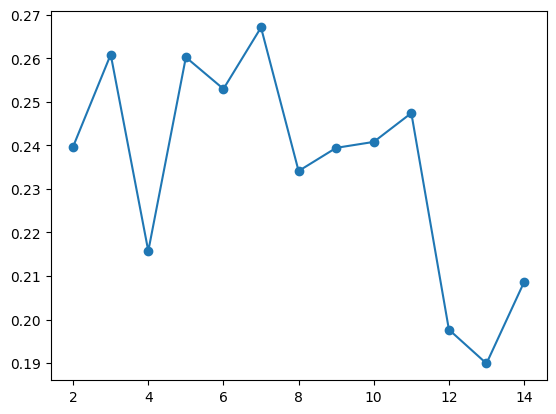

In [5]:
scaler = StandardScaler().fit()
X_norm = scaler.transform(data)
print(X_norm.shape)

silhouettes = []
for num_cluster in range(2, 15):
    cls = cluster.KMeans(n_clusters=num_cluster, n_init=1, init="random")
    cls.fit(X_norm)
    silh = metrics.silhouette_score(X_norm, cls.labels_)
    silhouettes.append(silh)

plt.plot(range(2, 15), silhouettes, marker='o')


For n_clusters = 3 The average silhouette_score is : 0.21340272312827524
For n_clusters = 5 The average silhouette_score is : 0.18049665641578022
For n_clusters = 7 The average silhouette_score is : 0.20832595178588284


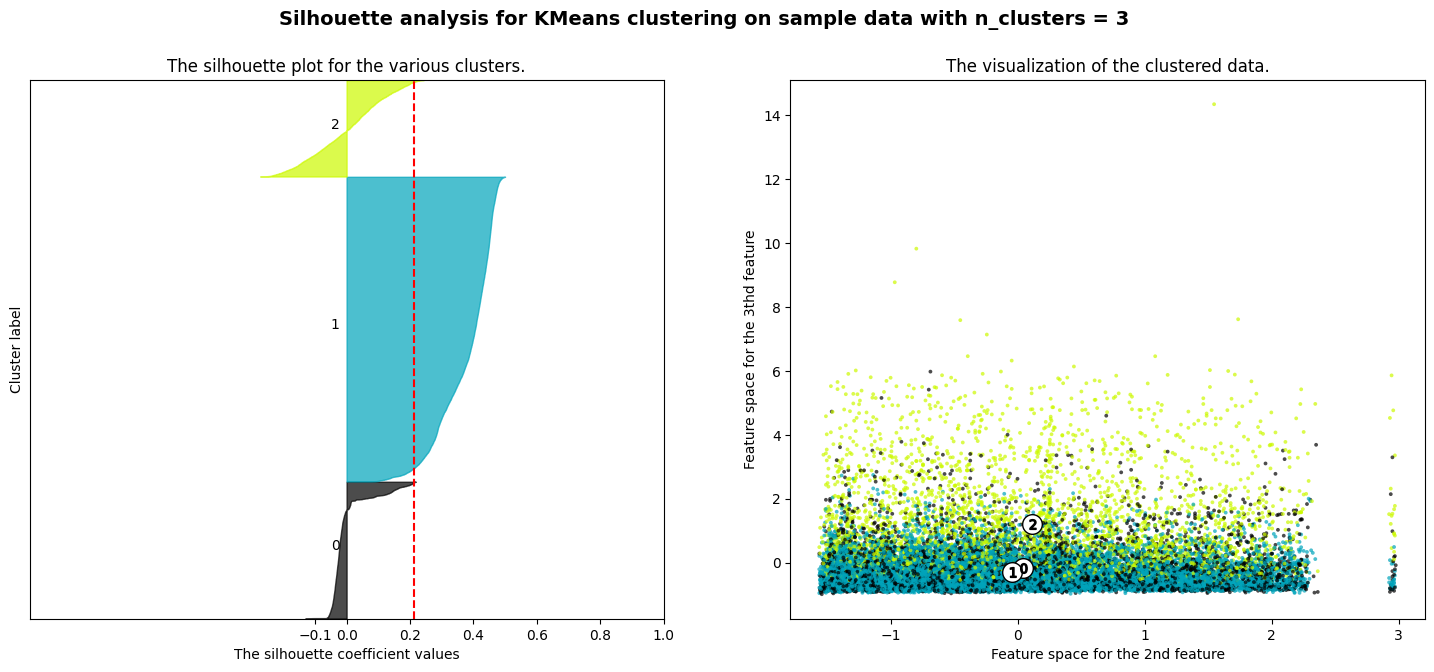

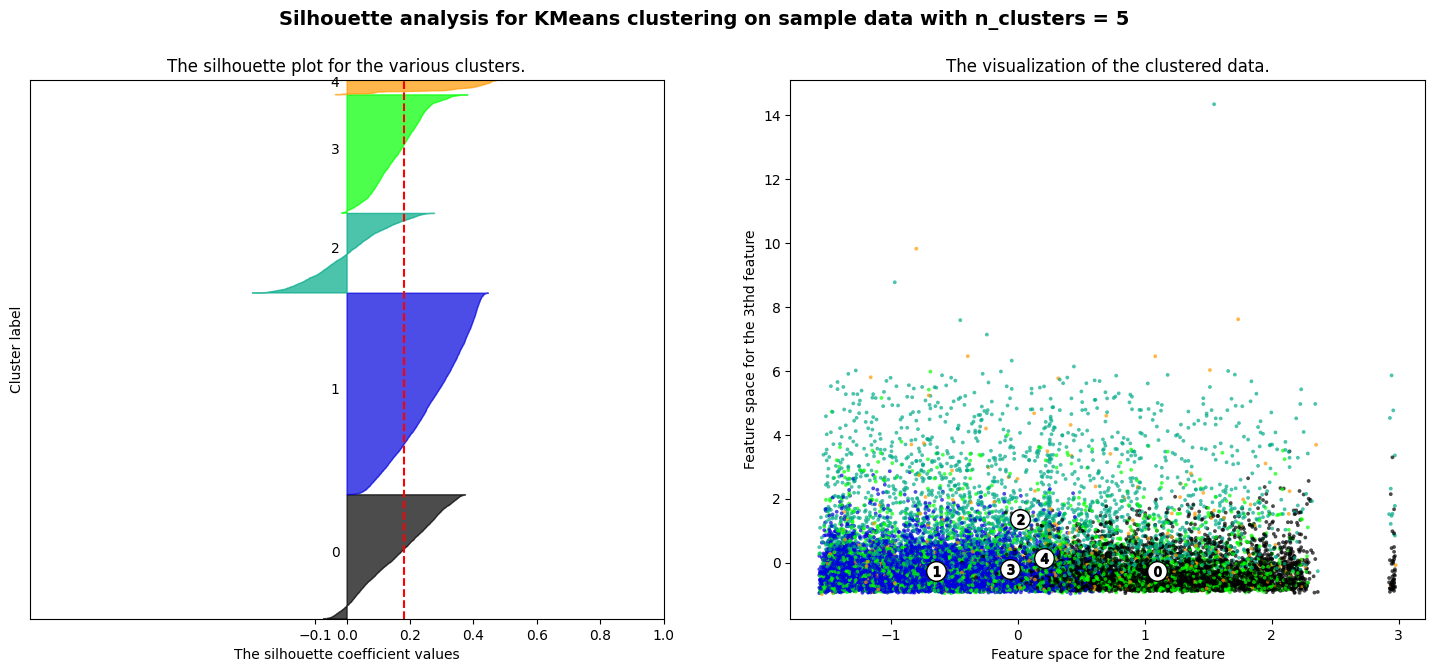

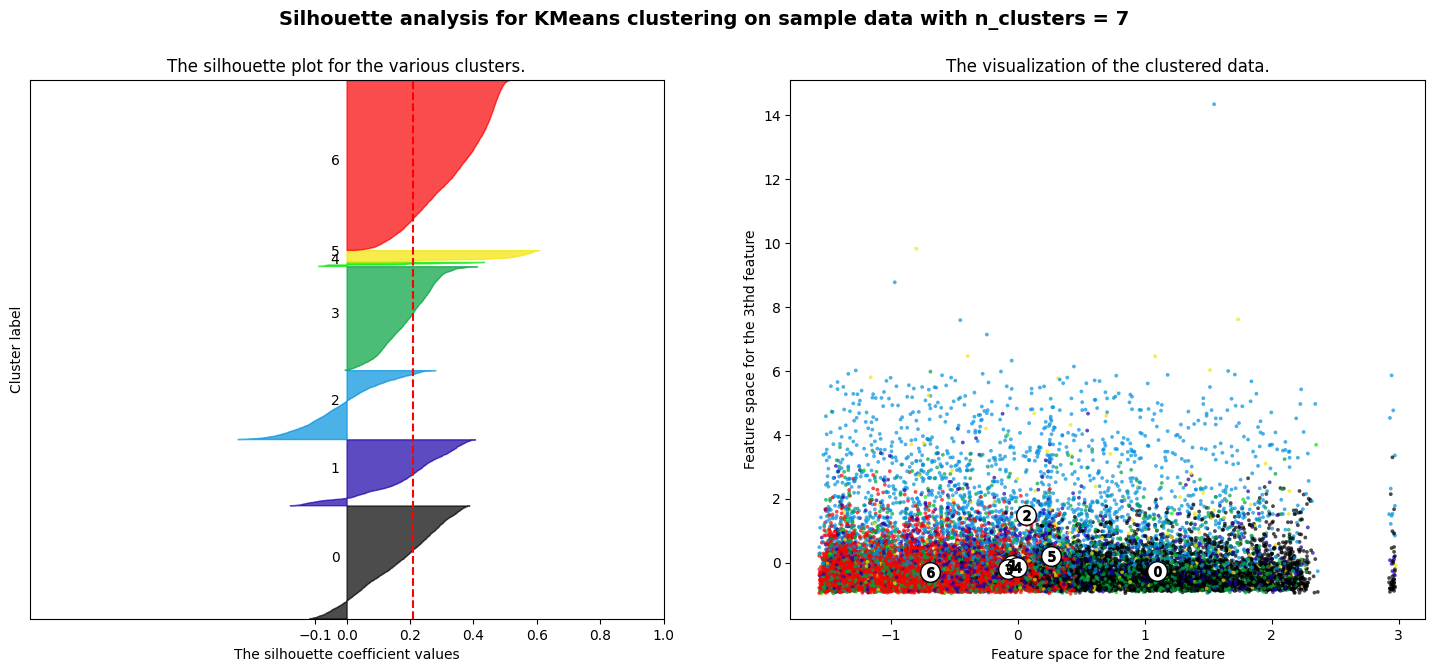

In [6]:
X_norm_sample = X_norm[:20000, :]
range_n_clusters = [3, 5, 7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_norm_sample) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X_norm_sample)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_norm_sample, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(
        X_norm_sample, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_norm_sample[:, 1], X_norm_sample[:, 2], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 1],
        centers[:, 2],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[1], c[2], marker="$%d$" %
                    i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 2nd feature")
    ax2.set_ylabel("Feature space for the 3thd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


# DBSCAN

In [11]:
X_norm_sample = X_norm[:20000, :]
epsilons = [0.5, 1, 5]
min_samples = [5, 10, 15]
for eps in epsilons:
    for min_ in min_samples:
        db = DBSCAN(eps=eps, min_samples=min_)
        db.fit(X_norm_sample)

        labels = db.labels_
        print(f"eps: {eps}, min_samples: {min_} => Silhouette Coefficient: {metrics.silhouette_score(X_norm_sample, labels):.3f}")


eps: 0.5, min_samples: 5 => Silhouette Coefficient: -0.118
eps: 0.5, min_samples: 10 => Silhouette Coefficient: -0.097
eps: 0.5, min_samples: 15 => Silhouette Coefficient: -0.053
eps: 1, min_samples: 5 => Silhouette Coefficient: 0.111
eps: 1, min_samples: 10 => Silhouette Coefficient: 0.131
eps: 1, min_samples: 15 => Silhouette Coefficient: 0.125
eps: 5, min_samples: 5 => Silhouette Coefficient: 0.598
eps: 5, min_samples: 10 => Silhouette Coefficient: 0.598
eps: 5, min_samples: 15 => Silhouette Coefficient: 0.598


In [ ]:
X_norm_sample = X_norm[:50000, :]
db = DBSCAN(eps=5, min_samples=10)
db.fit(X_norm_sample)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)


Estimated number of clusters: 3
Estimated number of noise points: 29


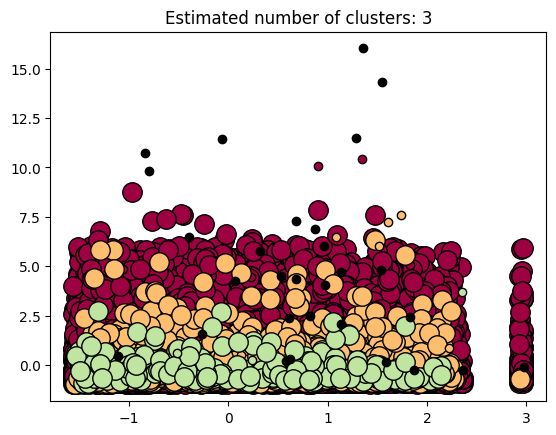

In [13]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X_norm_sample[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 1],
        xy[:, 2],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X_norm_sample[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 1],
        xy[:, 2],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()


# Agglomerative clustering

In [42]:
X_norm_sample_light = X_norm_b[:20000, :]
clustering = AgglomerativeClustering().fit(X_norm_sample_light)
cah_labels = clustering.labels_
print(
    f"Silhouette Coefficient: {metrics.silhouette_score(X_norm_sample_light, cah_labels):.2f}")


Silhouette Coefficient: 0.27


In [43]:
set(cah_labels)


{0, 1}

# Mise à jour clustering

In [45]:
base_v0 = pd.read_csv(f'{DATA_PATH}/processed/customers_base_2016-2017.csv')
base_v1 = pd.read_csv(f'{DATA_PATH}/processed/customers_base_2018-01.csv')
base_v2 = pd.read_csv(f'{DATA_PATH}/processed/customers_base_2018-02.csv')
base_v3 = pd.read_csv(f'{DATA_PATH}/processed/customers_base_2018-03.csv')
base_v4 = pd.read_csv(f'{DATA_PATH}/processed/customers_base_2018-04.csv')
base_v5 = pd.read_csv(f'{DATA_PATH}/processed/customers_base_2018-05.csv')
base_v6 = pd.read_csv(f'{DATA_PATH}/processed/customers_base_2018-06.csv')
base_v7 = pd.read_csv(f'{DATA_PATH}/processed/customers_base_2018-07.csv')
base_v8 = pd.read_csv(f'{DATA_PATH}/processed/customers_base_2018-08.csv')

files_list = [base_v0, base_v1, base_v2, base_v3,
              base_v4, base_v5, base_v6, base_v7, base_v8]


In [55]:
def prep_and_fit_data(df):
    if "customer_unique_id" in df.columns:
        df.drop(columns=["customer_unique_id"], inplace=True)
    df.dropna(inplace=True)
    scaler = StandardScaler().fit(df)
    df_scaled = scaler.transform(df)
    cls = KMeans(n_clusters=7, n_init=1, init="random", random_state=42)
    cls.fit(df_scaled)
    return cls, scaler


In [60]:
# files_list = glob.glob(f"{folder_path}/*{table}.csv")
# files_list.sort()
ARI_score = []

for i in range(1, 9):
    base_i = files_list[0]
    base_i1 = files_list[i]

    kmean_i, scaler_i = prep_and_fit_data(base_i)
    kmean_i1, scaler_i1 = prep_and_fit_data(base_i1)

    base_i1_scaledi = scaler_i.transform(base_i1)
    base_i1_scaledi1 = scaler_i1.transform(base_i1)

    labels_i = kmean_i.predict(base_i1_scaledi)
    labels_i1 = kmean_i1.predict(base_i1_scaledi1)

    ARI_score.append(adjusted_rand_score(labels_i, labels_i1))


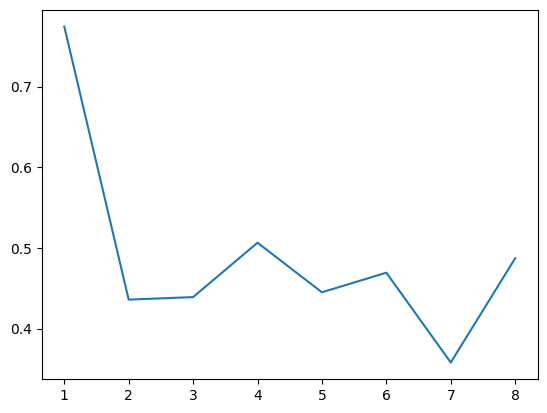

In [61]:
x = range(1, 9)
plt.plot(x, ARI_score)


# Kmeans, analyse des clusters

In [3]:
X_norm = scale(data)
cls = cluster.KMeans(n_clusters=7, n_init=1, init="random")
cls.fit(X_norm)
silh = metrics.silhouette_score(X_norm, cls.labels_)
print(silh)
customers_base.dropna(inplace=True)
labels_kmeans = cls.labels_
customers_base["labels_kmeans"] = labels_kmeans
customers_base.groupby("labels_kmeans").mean()


0.21516707152327708


In [6]:
customers_base.groupby("labels_kmeans").mean().sort_values(by="payment_value")


,review_score,recency,payment_value,payment_installments,payment_sequential,order_id,payment_type_num,customer_state_encoded,payment_type_encoded
labels_kmeans,,,,,,,,,
1,4.641882,127.872651,108.114097,2.334520,1.001321,1.005909,1.000000,143.372854,153.230714
4,4.608651,399.226061,108.590388,2.890542,1.001866,1.014628,1.000000,145.160619,153.177651
0,4.542223,239.079547,115.418743,1.000000,1.005907,1.015994,1.000000,144.689757,133.145014
5,1.410711,232.566277,137.453143,2.762521,1.001364,1.007898,1.000000,148.133771,149.609557
6,4.151851,265.108868,158.695586,1.618570,1.576608,1.186065,1.922407,149.474191,143.274257
2,4.284200,253.504422,164.516625,3.156711,1.002560,1.013499,1.000000,190.487822,149.007546
3,4.325312,250.087009,383.744296,7.528391,1.002333,1.171601,1.000302,147.811514,152.621750


In [23]:
X_norm = scale(data)
cls = cluster.KMeans(n_clusters=3, n_init=1, init="random")
cls.fit(X_norm)
silh = metrics.silhouette_score(X_norm, cls.labels_)
print(silh)
customers_base.dropna(inplace=True)
labels_kmeans = cls.labels_
customers_base["labels_kmeans"] = labels_kmeans
customers_base.groupby("labels_kmeans").mean()


0.20454290152308005


,review_score,recency,payment_value,payment_installments,payment_sequential,order_id,payment_type_num,customer_state_encoded,payment_type_encoded
labels_kmeans,,,,,,,,,
0,1.861799,240.942836,162.832259,3.271341,1.013583,1.027858,1.024542,150.059537,150.926632
1,4.745838,237.390289,150.445005,3.367639,1.014316,1.033761,1.025769,148.120585,153.230404
2,4.509497,243.192506,130.015322,1.009391,1.034652,1.036738,1.026294,148.266702,132.724795


## réduction des variables

In [35]:
df = customers_base[['review_score', 'recency', 'payment_value',
                     'payment_installments', 'customer_state_encoded', 'payment_type_encoded']]
df.dropna(inplace=True)
X_norm_df = scale(df)
cls = cluster.KMeans(n_clusters=5, n_init=1, init="random")
cls.fit(X_norm_df)
silh = metrics.silhouette_score(X_norm_df, cls.labels_)
print(silh)
labels_kmeans = cls.labels_
df["labels_kmeans"] = labels_kmeans
df.groupby("labels_kmeans").mean()


/Users/cyrielle/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


0.2444885022082025


,review_score,recency,payment_value,payment_installments,payment_sequential,order_id,payment_type_num,customer_state_encoded,payment_type_encoded
labels_kmeans,,,,,,,,,
0,4.086977,240.343722,618.576944,5.699316,1.013780,1.167040,1.031166,151.545157,150.764660
1,4.527601,243.174312,114.377136,1.006842,1.035264,1.030020,1.024700,148.124361,132.692496
2,4.564906,284.435745,179.931836,6.557676,1.007494,1.037243,1.010585,158.238162,153.224073
3,1.638672,242.234363,132.905825,2.710148,1.014127,1.019517,1.025280,150.188792,150.194613
4,4.691890,218.625057,104.025693,1.994472,1.016844,1.022756,1.031504,143.972147,153.230714


# DBSCAN, analyse des clusters

In [38]:
X_norm_b = X_norm_df[:60000, :]
db = DBSCAN(eps=1, min_samples=5)
db.fit(X_norm_b)
customers_base_db = customers_base.iloc[:60000, :]
labels_dbscan = db.labels_
customers_base_db["labels_dbscan"] = labels_dbscan
customers_base_db.groupby("labels_dbscan").mean()


/var/folders/t8/clhcfp2n5sgcs4b81syf8xym0000gp/T/ipykernel_954/605594032.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_base_db["labels_dbscan"] = labels_dbscan


,review_score,recency,payment_value,payment_installments,payment_sequential,order_id,payment_type_num,customer_state_encoded,payment_type_encoded,labels_kmeans
labels_dbscan,,,,,,,,,,
-1,3.192760,307.631579,614.990727,6.211640,1.077360,1.250627,1.105263,180.037833,144.396829,0.671679
0,4.180621,237.465523,150.076603,3.382952,1.014408,1.031720,1.025591,148.297609,153.230714,3.198142
1,4.179203,247.612145,133.040179,1.005666,1.000082,1.035244,1.011417,148.262119,136.082415,1.205262
2,4.225061,166.829684,111.161411,1.000000,1.026156,1.013382,1.001217,143.440236,124.737817,1.154501
3,4.175604,250.186069,94.239609,1.021962,1.378247,1.040076,1.177481,147.330463,105.954954,1.000000
4,1.083333,239.333333,662.475833,4.458333,1.041667,1.000000,1.083333,185.393198,153.230714,0.000000
5,4.596491,125.368421,143.094211,1.000000,1.070175,1.000000,1.000000,191.999894,124.737817,1.000000
6,4.555556,263.333333,110.438889,1.000000,1.000000,1.000000,1.000000,243.093067,136.082415,1.222222
7,1.000000,105.857143,738.231429,9.714286,1.000000,1.000000,1.000000,185.122417,153.230714,0.000000


In [39]:
customers_base_db["labels_dbscan"].value_counts()


 0     45523
 1     12087
 3      1048
 2       822
-1       399
 5        57
 4        12
 6         9
 7         7
 10        6
 8         5
 9         5
 14        5
 11        4
 12        4
 13        4
 15        3
Name: labels_dbscan, dtype: int64